<font face = 'Computer Modern', size = 4>

To Do:

<ul>
<li> Keep this notebook pretty </li>
<li> Figure out *explainable variance* </li>
<li> Cross validate on $\alpha$, # of PC's, # of history terms for ridge regression
    <ul>
        <li> With history filter </li>
        <li> With running speed filter </li>
    </ul>
    </li>
<li> Determine if non-linearity helps (i.e. repeat above with Sigmoid and Exponential non-linearity) </li>
</ul>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glm_model as gm
from glm_utils import *
import pprint
import allensdk.brain_observatory.stimulus_info as stim_info
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import tensorflow as tf

%load_ext autoreload
%autoreload 2
%matplotlib inline

boc = BrainObservatoryCache(manifest_file='boc/manifest.json')

In [2]:
print boc.get_all_targeted_structures(), boc.get_all_cre_lines(), boc.get_all_imaging_depths()

[u'VISal', u'VISl', u'VISp', u'VISpm'] [u'Cux2-CreERT2', u'Rbp4-Cre', u'Rorb-IRES2-Cre', u'Scnn1a-Tg3-Cre'] [175, 275, 350, 375]


In [3]:
import pandas as pd

# Download experiment containers for VISp experiments, with imaging depth 350 
visp_ecs = boc.get_experiment_containers(targeted_structures=['VISal'], cre_lines=['Rbp4-Cre'], imaging_depths=[375])
print("Experiment containers: %d" % len(visp_ecs))

# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))

# find direction selective cells in VISp
visp_ec_ids = [ ec['id'] for ec in visp_ecs ]
visp_cells = cells[cells['experiment_container_id'].isin(visp_ec_ids)]

print("Layer 5 cells from primary visual cortex: %d" % len(visp_cells))

ns_cells = visp_cells[(visp_cells['p_ns'] < 0.005) & (visp_cells['p_ns'] > 0)]

print("Cells that with significant response to natural scenes: %d" % len(ns_cells))


Experiment containers: 4
total cells: 18260
Layer 5 cells from primary visual cortex: 704
Cells that with significant response to natural scenes: 384


In [4]:
#these are the actual natural scenes experiments in those experiment containers. 

exp = boc.get_ophys_experiments(experiment_container_ids=list(ns_cells.experiment_container_id.unique()), stimuli = [stim_info.NATURAL_SCENES])

exp_id_list = [ec['id'] for ec in exp]

data_set = boc.get_ophys_experiment_data(exp_id_list[0]) 

map_dic = {exper['id']:exper['experiment_container_id'] for exper in exp}

In [5]:
len(data_set.get_cell_specimen_ids())

86

In [178]:
#get all the traces. 
#WRITE THIS IN A MORE EFFICIENT WAY!!!

from allensdk.brain_observatory.dff import compute_dff


time, dff = data_set.get_dff_traces()

#get the stimulus
scenes = data_set.get_stimulus_template('natural_scenes')
stim_table = data_set.get_stimulus_table(stim_info.NATURAL_SCENES)

#VISpm_cux2_175_dff[ds_num] = (dff_dict, scenes, stim_table)

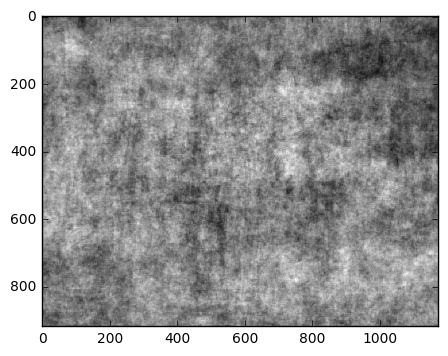

In [179]:
mean = np.mean(scenes, axis = 0)
plt.imshow(mean, cmap = 'gray')

scenes -= mean


std = np.std(scenes, axis = 0)

scenes /= std

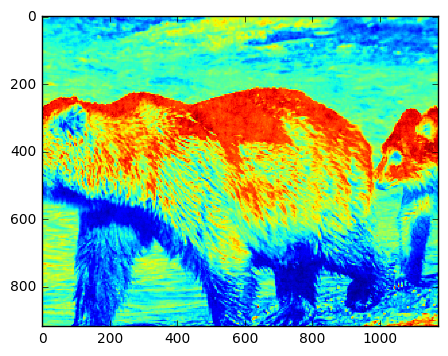

In [180]:
plt.imshow(scenes[0])

In [181]:
import cv2

lap_feats = []

for i in range(len(scenes)):
    G = cv2.resize(scenes[i], (50,50))

    gpA = [G]
    for i in xrange(4):
        G = cv2.pyrDown(gpA[i])
        gpA.append(G)

    lpA = [gpA[3]]
    for i in xrange(3,0,-1):
        size = (gpA[i-1].shape[1], gpA[i-1].shape[0])
        GE = cv2.pyrUp(gpA[i], dstsize = size)
        L = cv2.subtract(gpA[i-1],GE)
        lpA.append(L)

    feats = None
    for image in lpA:
        if feats == None:
            feats = np.array(image.flatten())
        else:
            feats = np.concatenate((feats, np.array(image.flatten())), axis = 0)
    lap_feats.append(feats)

/home/amy/.local/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


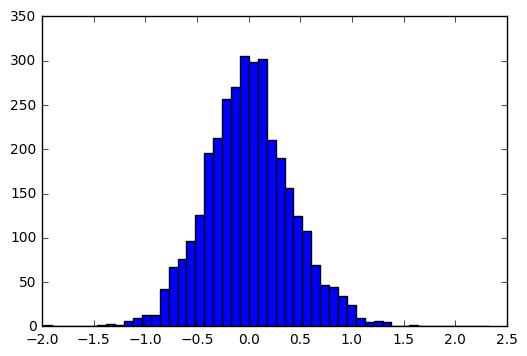

In [182]:
plt.hist(lap_feats[0], bins = 50);

In [41]:
from sklearn.decomposition import PCA

model = PCA()
scenes_r = model.fit_transform(scenes.reshape([len(scenes), -1]))

#, model.components_ 

In [183]:
dxcm, dxtime = data_set.get_running_speed()

#declare a dictionary of empty lists for each cell trace, 
#and a list for the stimulus
data = []
stim_array = []
run_speed = []

#average each trace over the presentation of each stimulus, and add
#to dictionary with cell id as keys

for index, row in stim_table.iterrows():    
    stim_array.append(lap_feats[row.frame])
    run_speed.append(np.average(dxcm[row['start']:row['end']])) 
    data.append(np.average(dff[:, row['start']:row['end']], axis = 1))

stim_array = np.array(stim_array)
data = np.array(data)
run_speed = np.array(run_speed)  


In [184]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale

import pyprind

#hyperparameters to crossvalidate across

alpha = np.logspace(-10, -3, num = 10)

results = {}
progbar = pyprind.ProgBar(len(alpha))

#stim_array = scale(stim_array, axis = 1)


#just play with the first cell for now. 
X_train, X_test, y_train, y_test = train_test_split(stim_array, data[:, 1])

scores = np.zeros(alpha.shape)
weights = np.zeros([len(alpha), stim_array.shape[1]])

for i, a in enumerate(alpha):

    progbar.update()
        
    model = Lasso(a, fit_intercept= True)        
    model.fit(X_train, y_train)

    #calculate r2 on both the training and test data
    #r2_train = model.score(X_train, y_train)
    r2_test = model.score(X_test, y_test)

    scores[i] = r2_test

    w = model.coef_

    weights[i, :] = w


0%      100%
[##########] | ETA: 00:00:00
Total time elapsed: 00:02:30


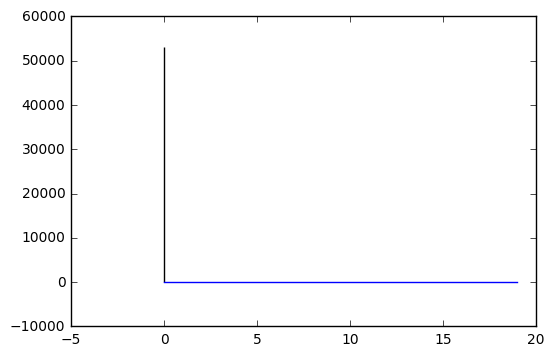

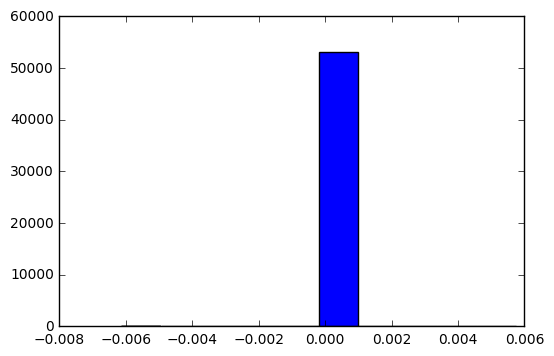

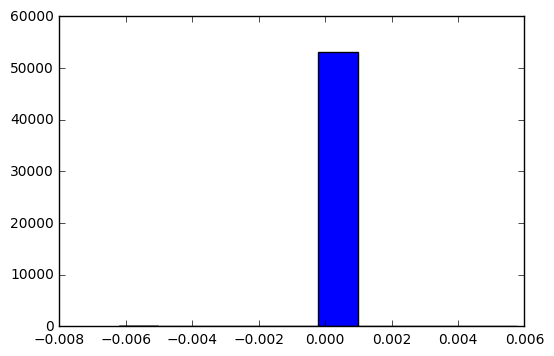

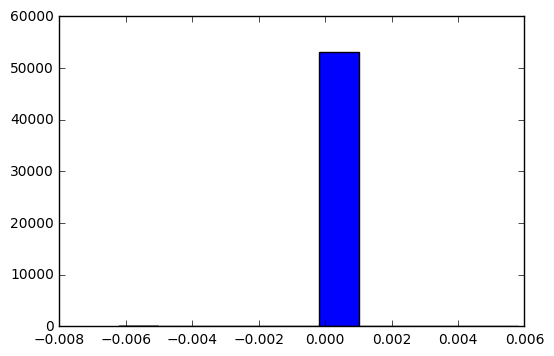

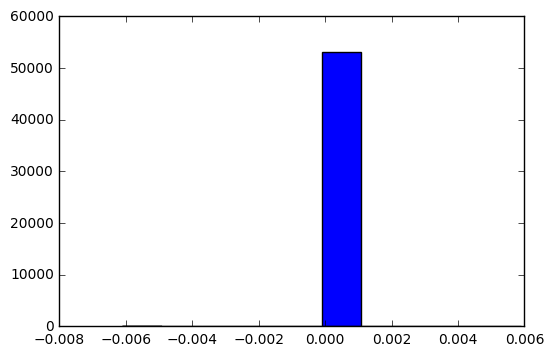

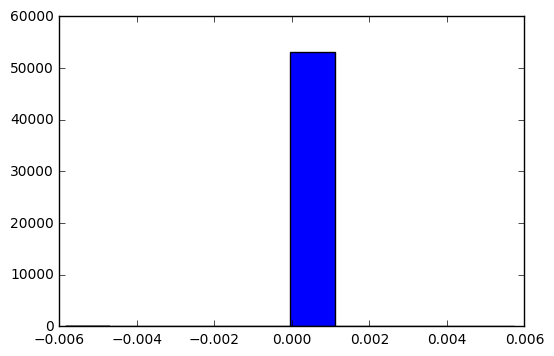

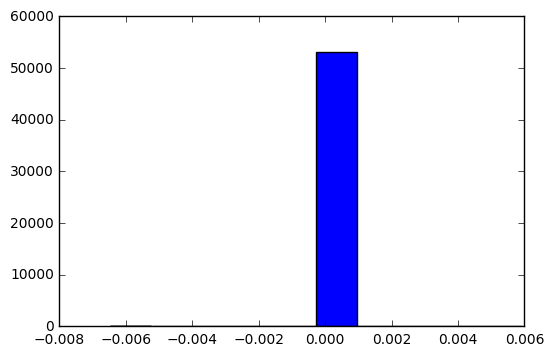

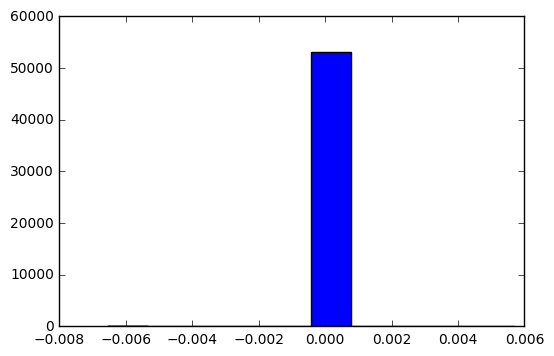

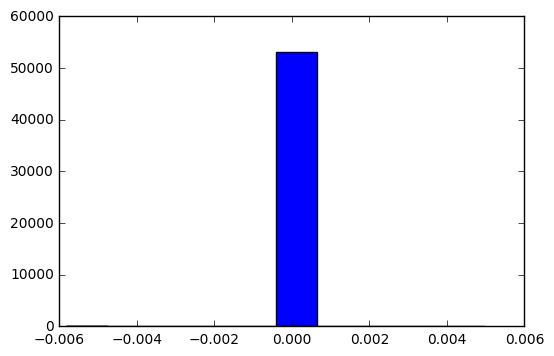

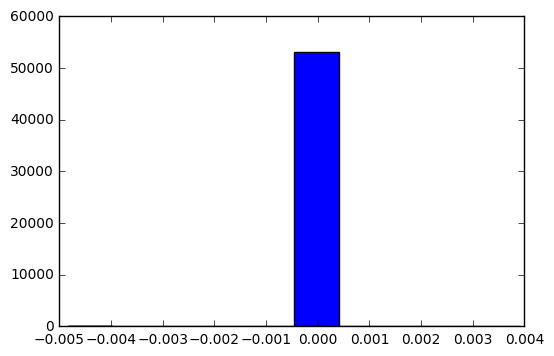

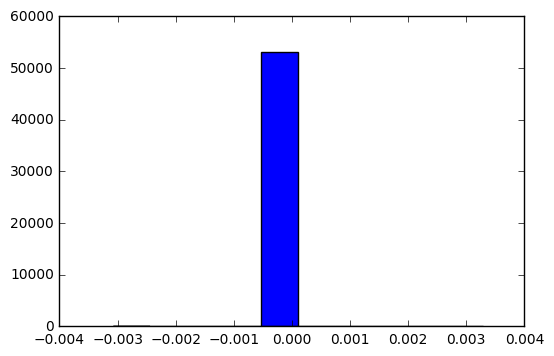

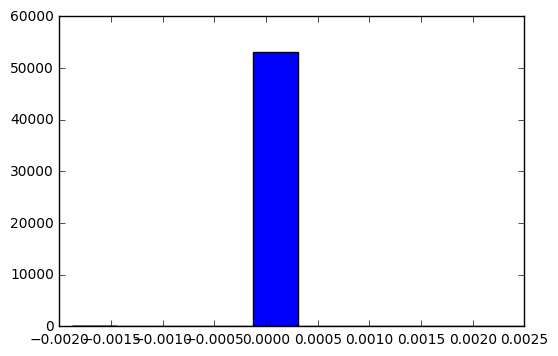

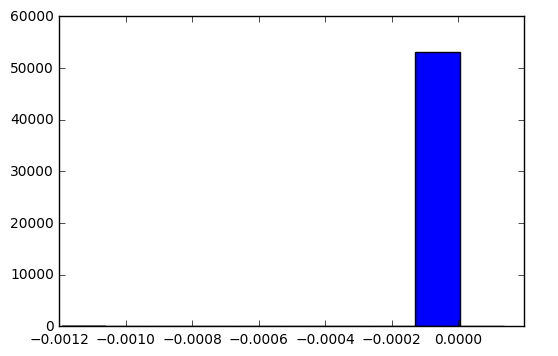

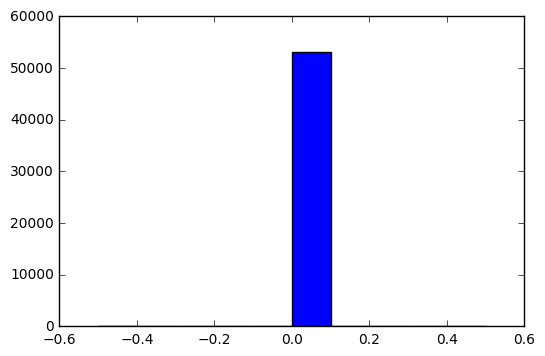

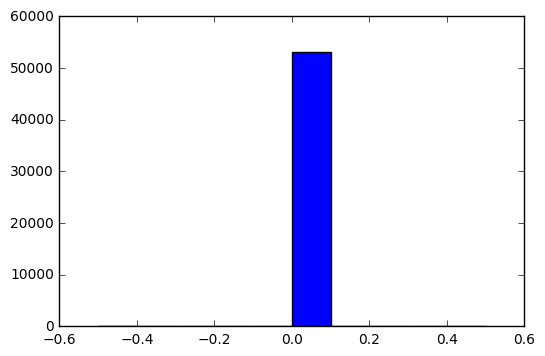

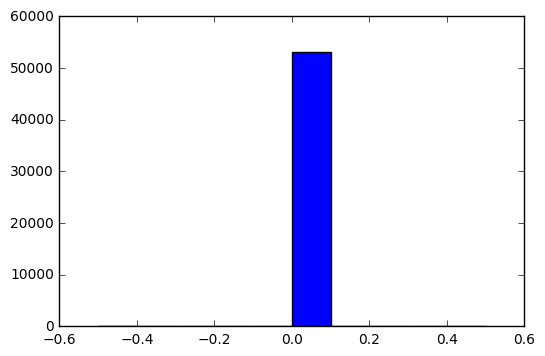

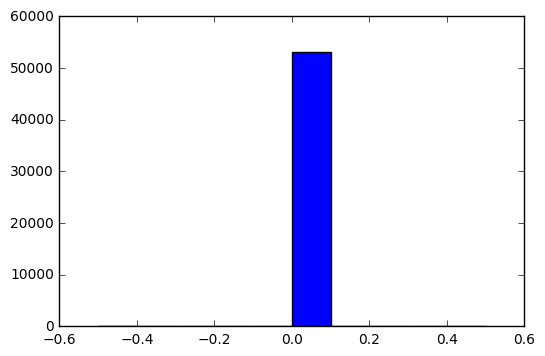

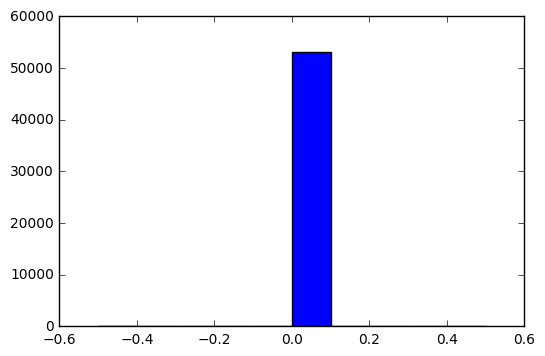

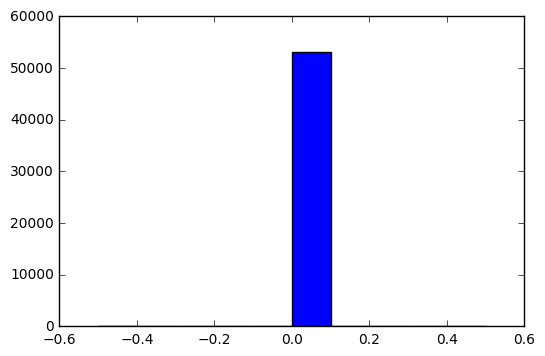

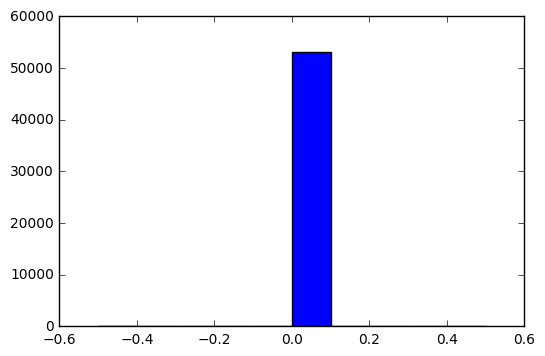

In [175]:
plt.plot(scores)

for i in range(len(alpha)):
    plt.hist(weights[i, :])
    plt.show()

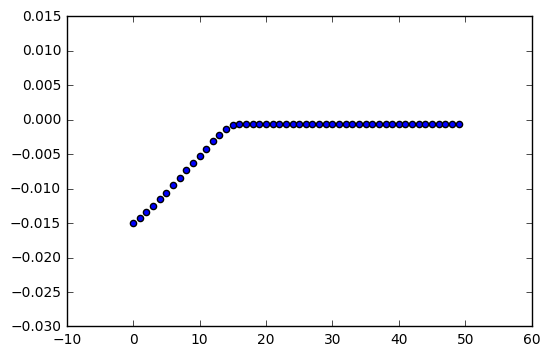

In [154]:
plt.scatter(range(len(scores)), scores)

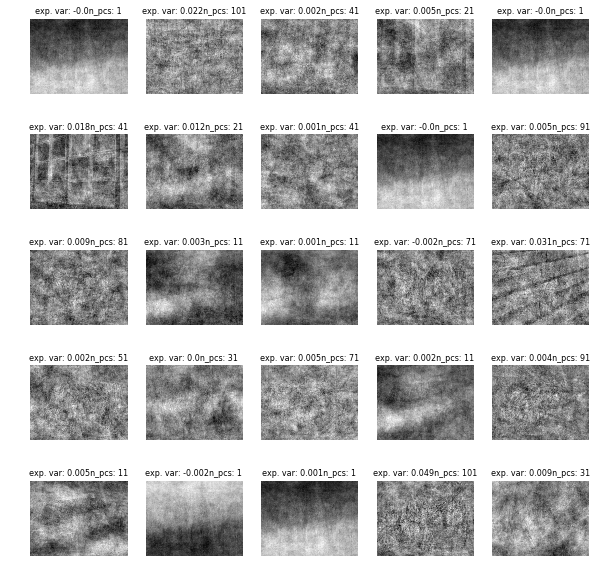

In [93]:

figure = plt.figure(figsize=[10, 10])
gs, ax = gridplot(5, 5)


for key in results:
    best_model = results[key][1]
    scenes_r, basis = scenes[key]
    
    for i, c in enumerate(best_model):
        w = best_model[c][2]
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(w.T.dot(basis[0:len(w), :]).reshape(s[0].shape), cmap = 'gray')
        plt.axis('off')
        plt.title('exp. var: ' + str(round(best_model[c][0], 3)) + 'n_pcs: ' + str(best_model[c][1]), fontsize= 8)
        #plt.colorbar(ax = ax, drawedges = False)
        if i >= 24:
            break
    plt.show()

    break
    

In [70]:
i

20

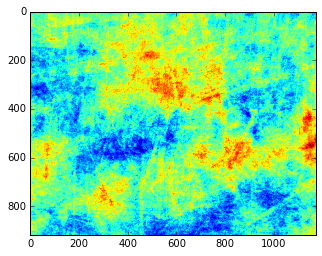

In [46]:
plt.imshow(w.T.dot(basis[0:22, :]).reshape(s[0].shape))

<font face= 'Computer Modern' size = 4>

To calculate the explainable variance for each cell, first I calculate the cells mean response to each image, then construct an array the same shape as the cells trace, where each element is it's mean response to the stimulus that was shown. 

I think perform a linear regression of the average response vs. the actual response, and record the $r^2$ of that model.

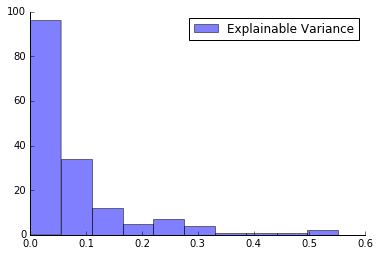

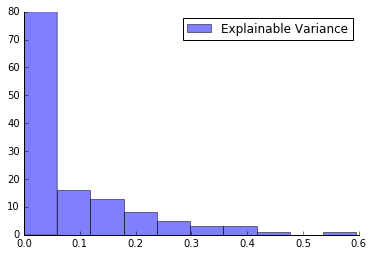

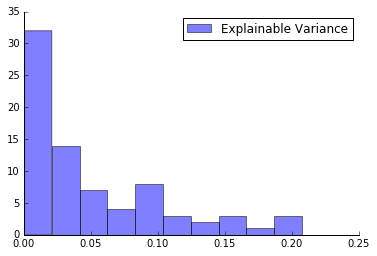

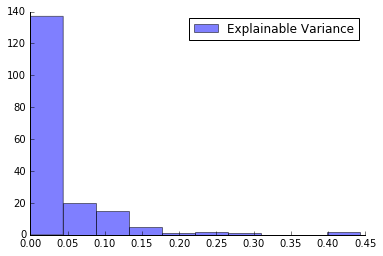

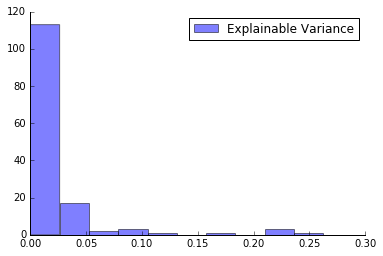

In [219]:
from sklearn.linear_model import LinearRegression
#let's try this explainable variance dealio

for key in results_run.keys():
    
    data, im_array = stimulus[key][0], stimulus[key][3]
    rishi_alex = {k: [] for k in data.keys()}

    av_1 = np.zeros(118)
    av_2 = np.zeros(118)

    for c in data.keys():
        dff = np.array(data[c]) 
        for image in range(118):
            idx  = np.where(im_array == image)

            idx = idx[0]

            ind1 = idx[idx > len(im_array)/2.0]
            ind2 = idx[idx < len(im_array)/2.0]

            ave1 = np.mean(dff[ind1])
            ave2 = np.mean(dff[ind2])
            av_1[image] = ave1   
            av_2[image] = ave2

        #X = np.concatenate((run_speed[:, np.newaxis], av_r[:, np.newaxis]), axis = 1)   

        slope, intercept, r_value, p_value, std_err = linregress(av_1, av_2)
        rishi_alex[c] = r_value**2 
        #plot the distribution of "explainable variance"

    bins = np.linspace(.01, .03, 5)
    ax = plt.subplot(111)
    plt.hist(rishi_alex.values(), alpha=0.5, label='Explainable Variance')
    plt.legend(loc='upper right')
    simpleaxis(ax)
    plt.show()


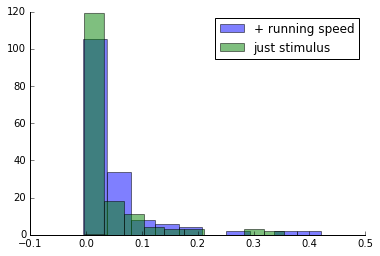

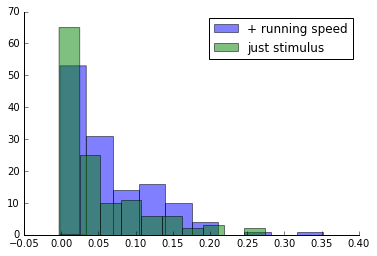

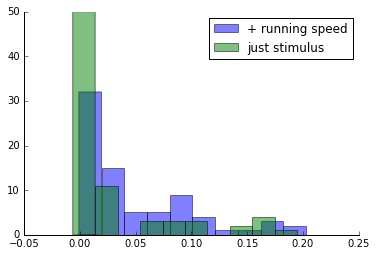

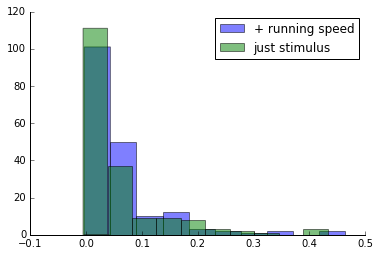

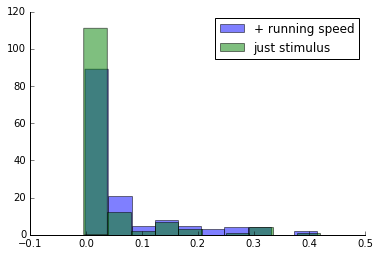

In [220]:
for key in results.keys():
    best_model = results_run[key][1]
    best_model2 = results[key][1]
    
    explained_var = []
    explained_var2 = []
    for k in best_model.keys():
        explained_var.append(best_model[k][0])
        explained_var2.append(best_model2[k][0])
    
    ax = plt.subplot(111)
    plt.hist(explained_var, alpha=0.5, label='+ running speed')
    plt.hist(explained_var2, alpha=0.5, label='just stimulus')
    plt.legend(loc='upper right')
    simpleaxis(ax)
    plt.show()

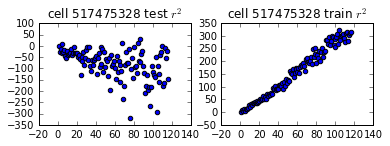

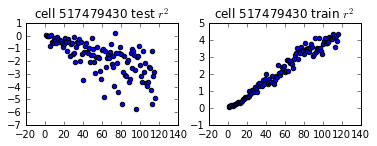

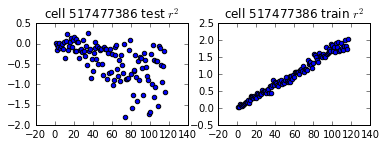

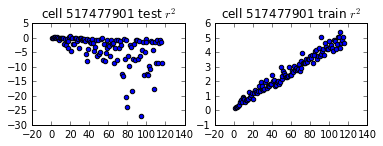

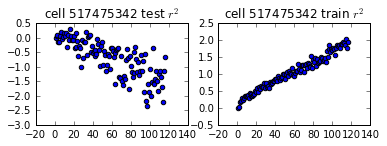

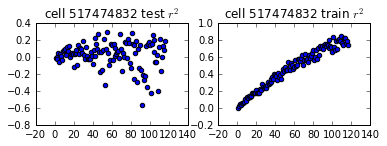

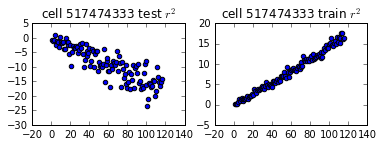

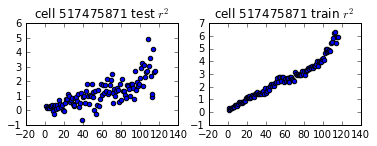

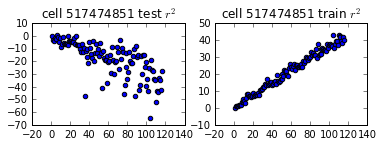

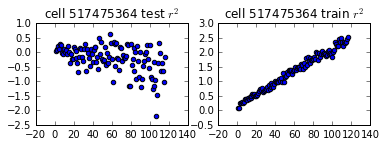

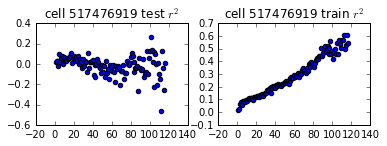

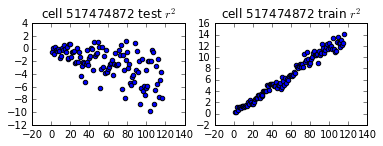

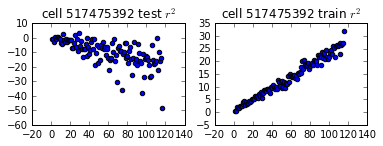

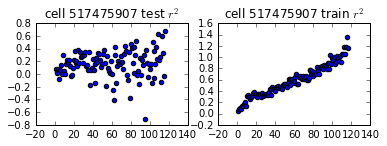

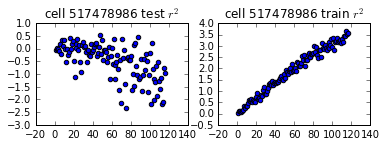

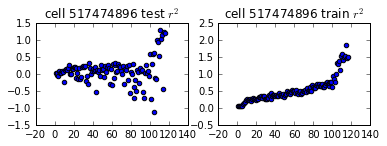

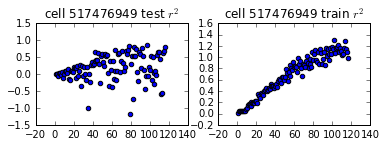

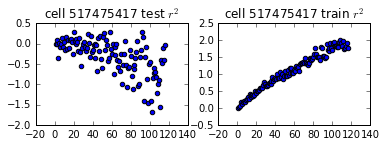

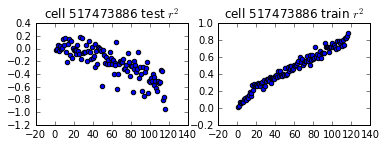

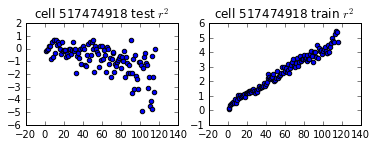

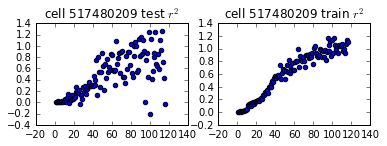

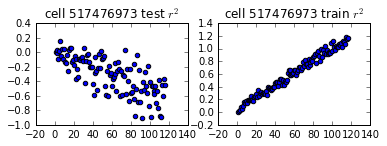

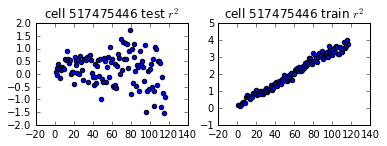

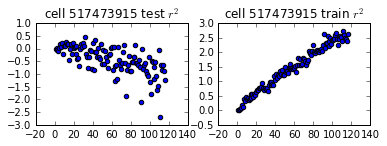

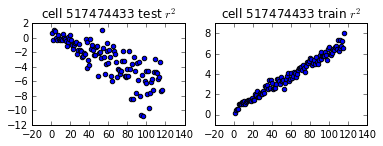

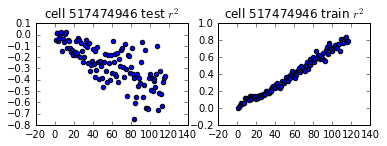

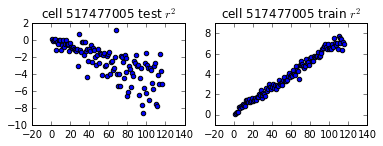

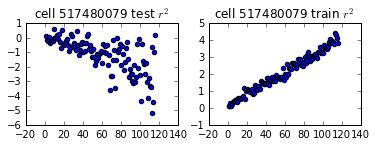

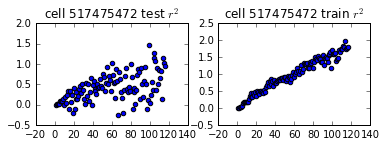

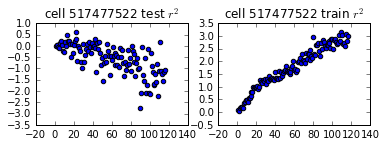

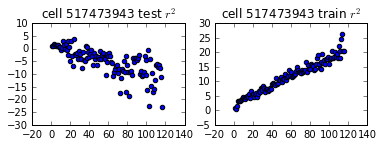

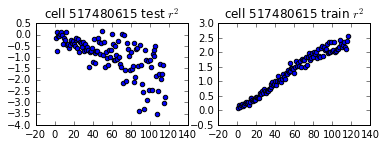

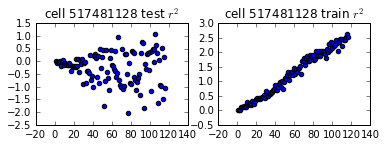

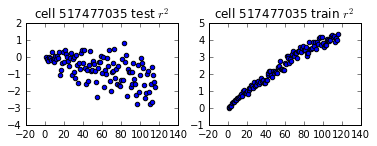

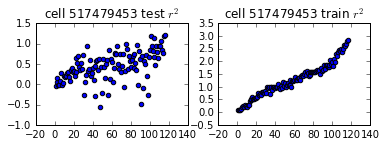

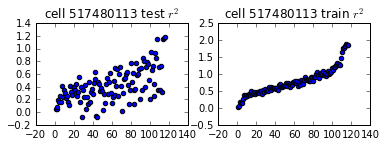

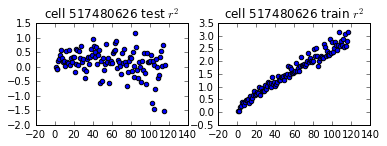

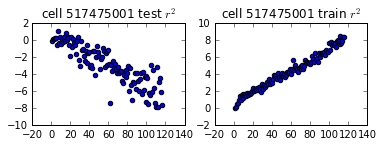

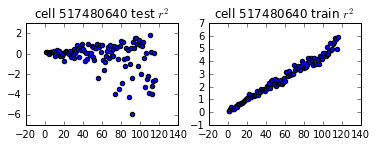

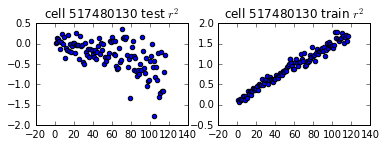

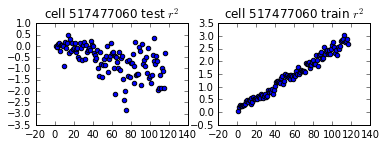

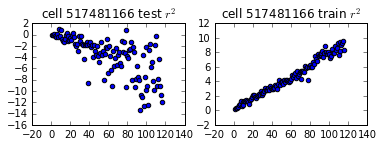

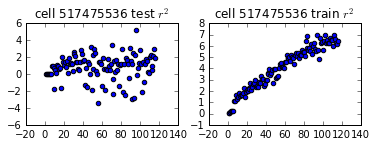

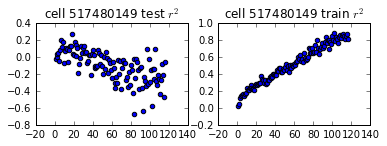

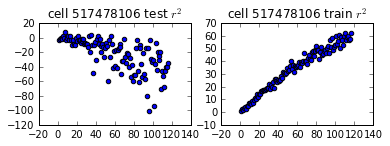

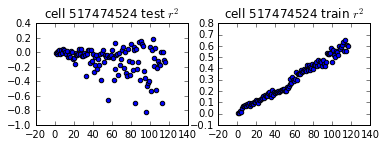

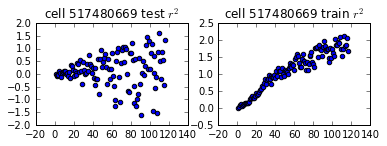

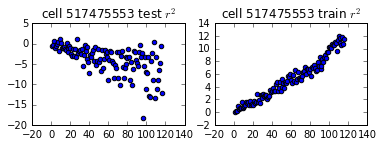

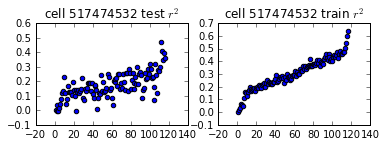

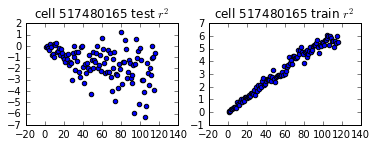

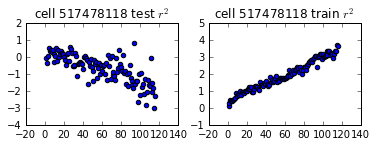

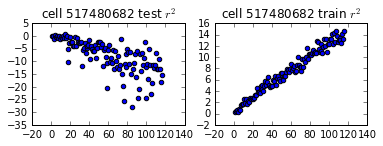

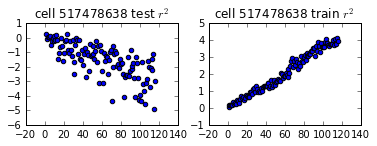

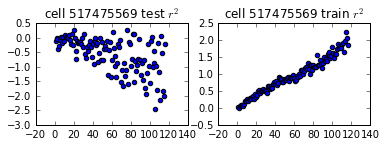

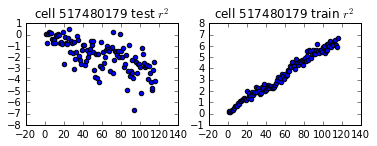

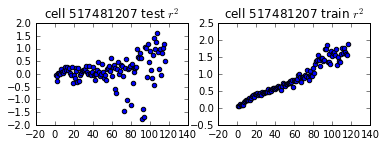

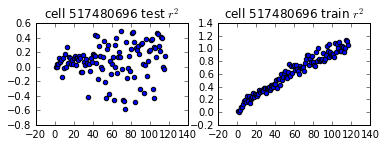

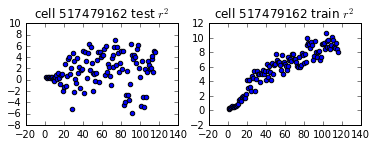

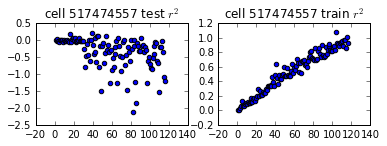

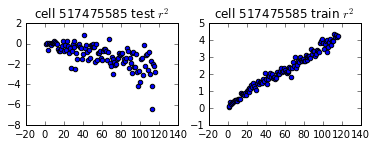

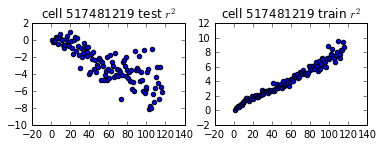

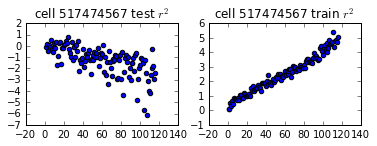

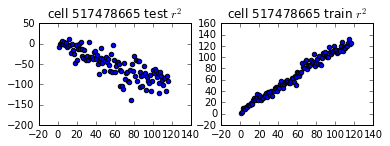

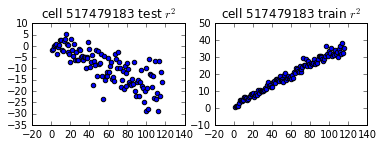

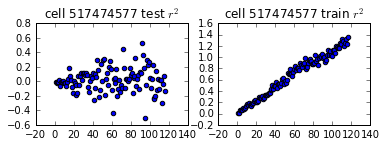

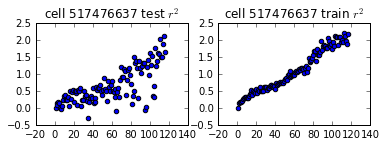

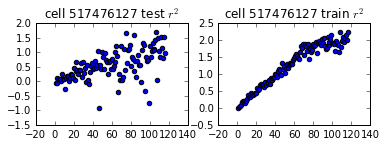

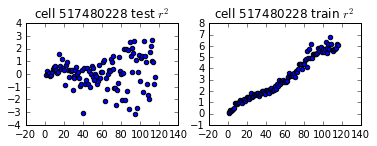

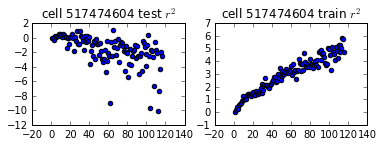

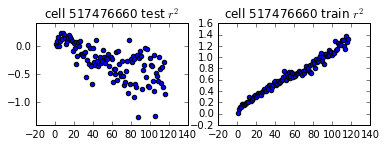

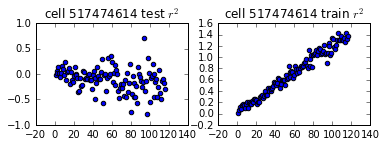

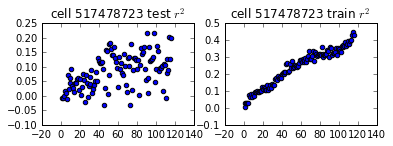

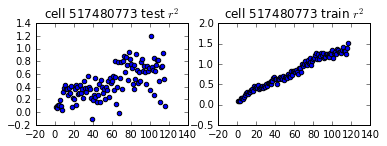

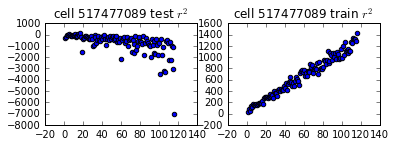

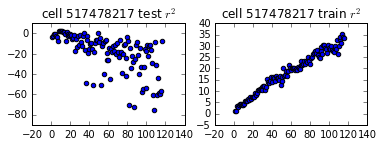

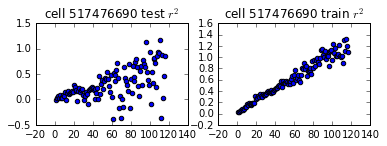

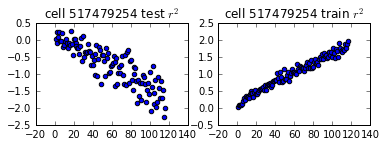

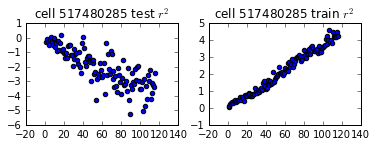

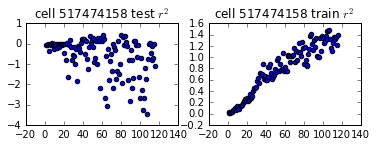

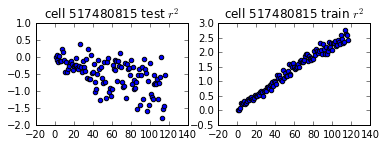

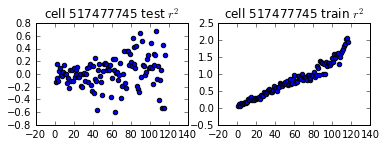

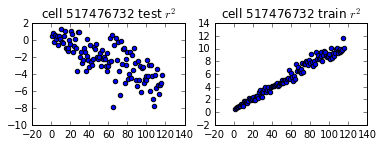

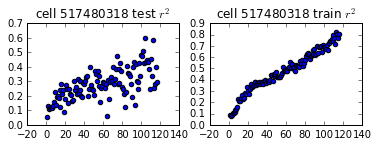

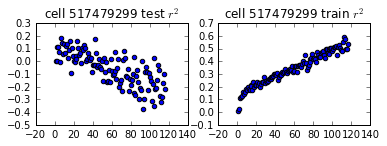

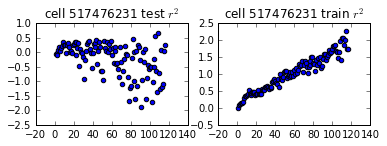

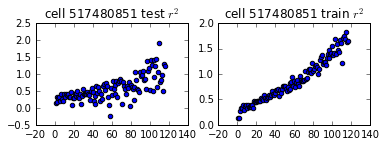

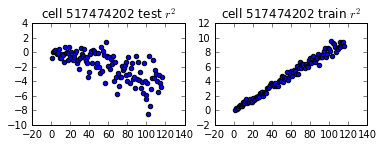

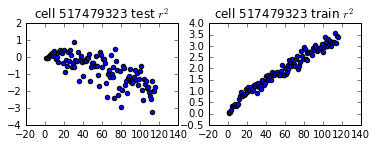

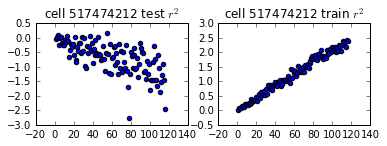

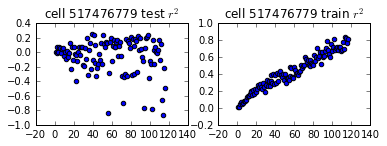

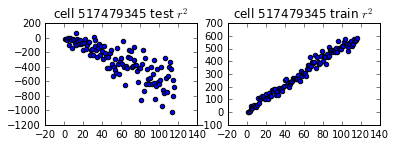

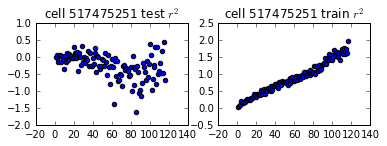

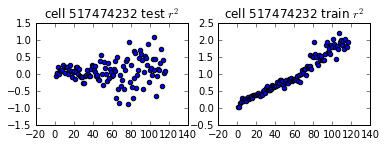

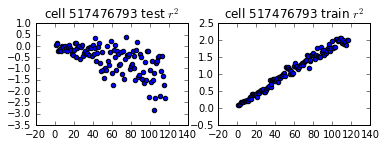

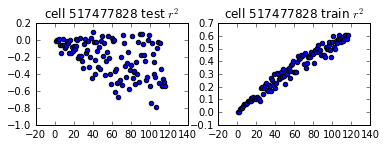

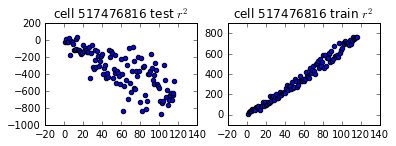

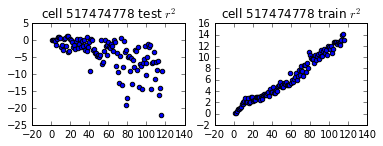

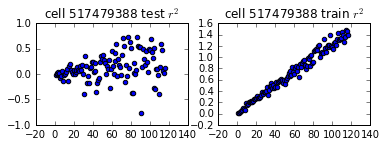

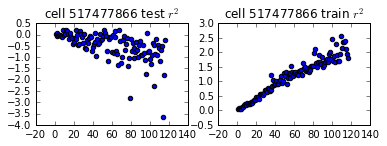

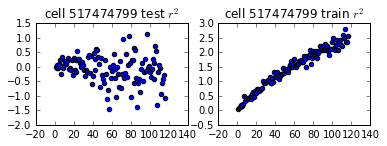

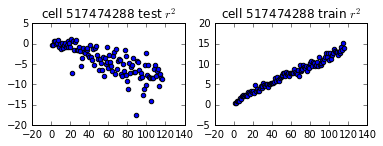

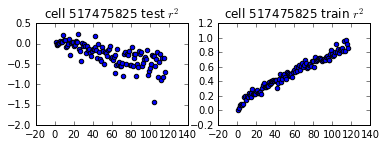

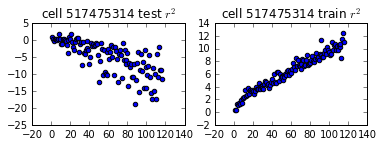

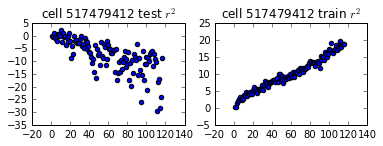

In [19]:
#first let's calculate some aggregate statistics - and plot how explained variance goes with lag for each cell
for c in data.keys():
    
    ra_var = rishi_alex[c]
    
    plt.subplot(221)
    for n in scores_dict[c].keys():
        plt.scatter(n, scores_dict[c][(n)][0] / ra_var)
     
    plt.title('cell ' + str(c) + ' test $r^2$')
    
    plt.subplot(222)   
    for n in scores_dict[c].keys():
        plt.scatter(n, scores_dict[c][n][1] / ra_var)
     
    plt.title('cell ' + str(c) + ' train $r^2$')
    plt.show()
  

<font face = 'Computer Modern', size = 4>

From the above it's obvious both that the models are overfitting, and that things are fairly consistant from cell to cell. 

let's see what the best model parameters were!


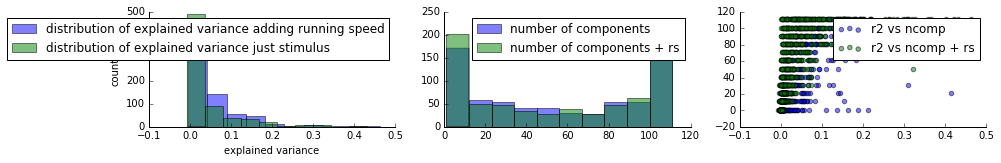

In [221]:
variance = []
variance2 = []
n_components = []
n_components2 = []

for key in results.keys():
    data, best_model = stimulus[key][0], results_run[key][1]
    best_model2 = results[key][1]
    
    for c in data.keys():
        (v, n) = best_model[c]
        (v2, n2) = best_model2[c]
        
        n_components.append(n)
        n_components2.append(n2)
        
        variance.append(v)
        variance2.append(v2)

plt.figure(figsize = [15, 7])
ax = plt.subplot(331)
plt.hist(variance, alpha = .5, label = 'distribution of explained variance adding running speed')
plt.hist(variance2, alpha = .5, label = 'distribution of explained variance just stimulus')
plt.legend(loc='upper right')
plt.ylabel('counts')
plt.xlabel('explained variance')
simpleaxis(ax)

ax = plt.subplot(332)
plt.hist(n_components, alpha = .5, label = 'number of components')
plt.hist(n_components2, alpha = .5, label = 'number of components + rs')
plt.legend(loc = 'upper right')
simpleaxis(ax)

ax = plt.subplot(333)
plt.scatter(variance, n_components, alpha = .5, label = 'r2 vs ncomp')
plt.scatter(variance2, n_components2, alpha = .5, c= 'g', label = 'r2 vs ncomp + rs')
plt.legend(loc = 'upper right')
simpleaxis(ax)

In [222]:
from scipy.stats import ttest_rel

ttest_rel(variance, variance2)

Ttest_relResult(statistic=10.248012609181151, pvalue=4.8274137695621153e-23)

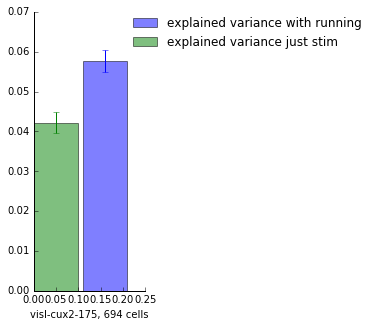

In [223]:
plt.figure(figsize = [2, 5])


ax = plt.subplot(111)
plt.bar(.11, np.mean(variance), width = .1, yerr = np.std(variance)/np.sqrt(len(variance)), alpha = .5, label = 'explained variance with running')
plt.bar(0, np.mean(variance2), width = .1, yerr = np.std(variance2)/np.sqrt(len(variance)), alpha = .5, color = 'g', label = 'explained variance just stim')
plt.legend(loc = (.85, .85), frameon = False)
plt.xlabel('visl-cux2-175, 694 cells')
simpleaxis(ax)

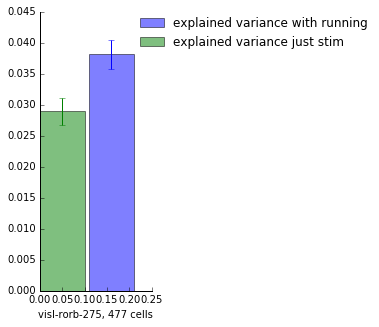

In [196]:
plt.figure(figsize = [2, 5])


ax = plt.subplot(111)
plt.bar(.11, np.mean(variance), width = .1, yerr = np.std(variance)/np.sqrt(len(variance)), alpha = .5, label = 'explained variance with running')
plt.bar(0, np.mean(variance2), width = .1, yerr = np.std(variance2)/np.sqrt(len(variance)), alpha = .5, color = 'g', label = 'explained variance just stim')
plt.legend(loc = (.85, .85), frameon = False)
plt.xlabel('visl-rorb-275, 477 cells')
simpleaxis(ax)

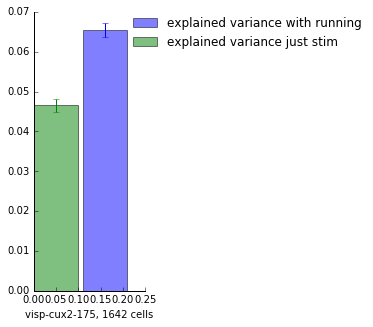

In [122]:
plt.figure(figsize = [2, 5])


ax = plt.subplot(111)
plt.bar(.11, np.mean(variance), width = .1, yerr = np.std(variance)/np.sqrt(len(variance)), alpha = .5, label = 'explained variance with running')
plt.bar(0, np.mean(variance2), width = .1, yerr = np.std(variance2)/np.sqrt(len(variance)), alpha = .5, color = 'g', label = 'explained variance just stim')
plt.legend(loc = (.85, .85), frameon = False)
plt.xlabel('visp-cux2-175, 1642 cells')
simpleaxis(ax)

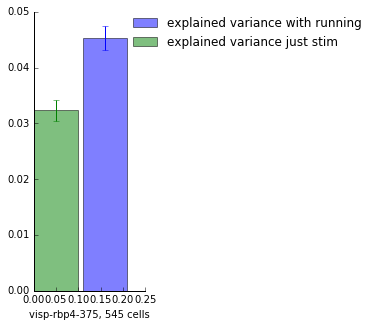

In [137]:
plt.figure(figsize = [2, 5])


ax = plt.subplot(111)
plt.bar(.11, np.mean(variance), width = .1, yerr = np.std(variance)/np.sqrt(len(variance)), alpha = .5, label = 'explained variance with running')
plt.bar(0, np.mean(variance2), width = .1, yerr = np.std(variance2)/np.sqrt(len(variance2)), alpha = .5, color = 'g', label = 'explained variance just stim')
plt.legend(loc = (.85, .85), frameon = False)
plt.xlabel('visp-rbp4-375, 545 cells')
simpleaxis(ax)

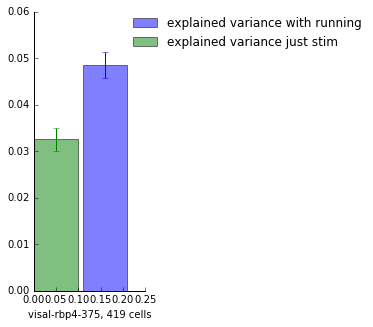

In [150]:
plt.figure(figsize = [2, 5])


ax = plt.subplot(111)
plt.bar(.11, np.mean(variance), width = .1, yerr = np.std(variance)/np.sqrt(len(variance)), alpha = .5, label = 'explained variance with running')
plt.bar(0, np.mean(variance2), width = .1, yerr = np.std(variance2)/np.sqrt(len(variance2)), alpha = .5, color = 'g', label = 'explained variance just stim')
plt.legend(loc = (.85, .85), frameon = False)
plt.xlabel('visal-rbp4-375, 419 cells')
simpleaxis(ax)

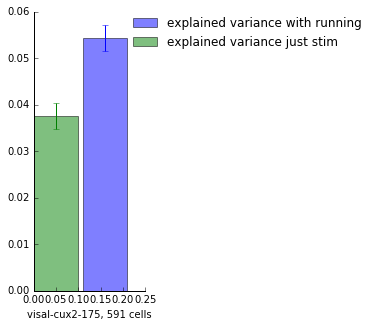

In [163]:
plt.figure(figsize = [2, 5])

ax = plt.subplot(111)
plt.bar(.11, np.mean(variance), width = .1, yerr = np.std(variance)/np.sqrt(len(variance)), alpha = .5, label = 'explained variance with running')
plt.bar(0, np.mean(variance2), width = .1, yerr = np.std(variance2)/np.sqrt(len(variance2)), alpha = .5, color = 'g', label = 'explained variance just stim')
plt.legend(loc = (.85, .85), frameon = False)
plt.xlabel('visal-cux2-175, 591 cells')
simpleaxis(ax)

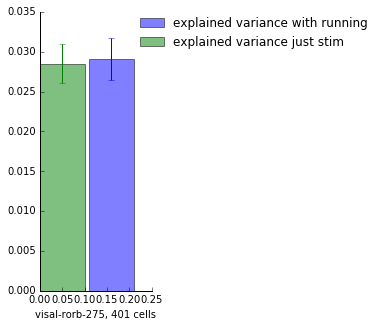

In [177]:
plt.figure(figsize = [2, 5])

ax = plt.subplot(111)
plt.bar(.11, np.mean(variance), width = .1, yerr = np.std(variance)/np.sqrt(len(variance)), alpha = .5, label = 'explained variance with running')
plt.bar(0, np.mean(variance2), width = .1, yerr = np.std(variance2)/np.sqrt(len(variance2)), alpha = .5, color = 'g', label = 'explained variance just stim')
plt.legend(loc = (.85, .85), frameon = False)
plt.xlabel('visal-rorb-275, 401 cells')
simpleaxis(ax)

In [138]:
import pickle

output = open('./boc/formatted/VISp375rbp4/linear_results.pkl', 'wb')

data = {'ra_var': ra_var, 'results': results, 'results_run': results_run, 'notes': 'tested every 10 pcs from 1 to 117'}

pickle.dump(data, output)
output.close()

In [139]:
import pickle

output = open('./boc/formatted/VISp375rbp4/data_set.pkl', 'wb')

pickle.dump(stimulus, output)
output.close()